In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import os
import keras
from keras_unet.models import custom_unet

Populating the interactive namespace from numpy and matplotlib


2023-03-29 18:02:22.580990: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [2]:
DATAPATH = '/raid/mpsych/CACTAS/DATA/ESUS/'
images_file = os.path.join(DATAPATH, 'images.npy')
labels_file = os.path.join(DATAPATH, 'labels.npy')

In [3]:
images = np.load(images_file)
labels = np.load(labels_file)

In [4]:
# full dataset does not have the last channel
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)

In [5]:
p = np.random.permutation(len(images))

In [6]:
images = images[p]
labels = labels[p]

In [7]:
labels = labels.astype(np.float64)

In [8]:
images = images.astype(np.float64)

for i in range(images.shape[0]):
    
    images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually
    

In [9]:
images.shape, labels.shape

((766, 512, 512, 1), (766, 512, 512, 1))

In [10]:
import json

In [11]:
with open("image_data_v3.json", "r") as fp:
    image_data = json.load(fp)
with open("label_data_v3.json", "r") as fp:
    label_data = json.load(fp)

In [12]:
X_train = images[0:image_data['82']]
y_train = labels[0:label_data['82']]
X_val = images[image_data['82']:]
y_val = labels[label_data['82']:]

In [13]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    X_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=5.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=40,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2, 512, 512, 1) (2, 512, 512, 1)


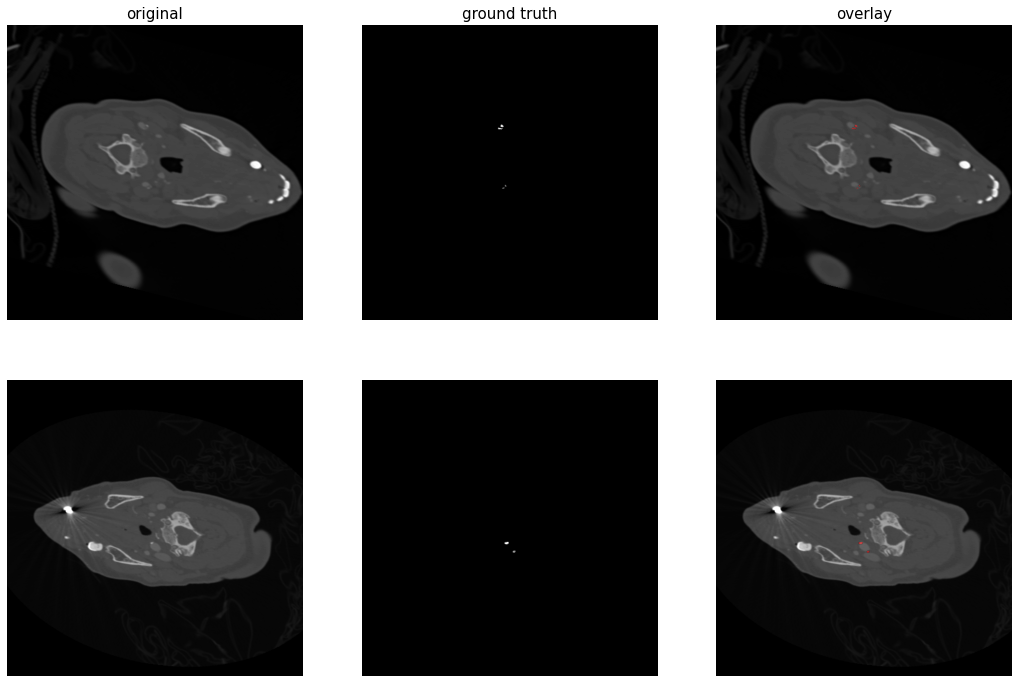

In [14]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)


In [15]:
model = custom_unet(
    input_shape=(512, 512, 1),
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.5,
    output_activation='sigmoid')

2023-03-29 18:02:56.738420: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-03-29 18:02:56.884065: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-03-29 18:02:56.884103: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-03-29 18:02:56.902003: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-03-29 18:02:56.902045: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-03-29 18:02:56.903380: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2

In [16]:
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance
from tensorflow.keras.optimizers import Adam

In [17]:
model.compile(optimizer = Adam(),    
              loss='binary_crossentropy', 
              metrics=[iou, iou_thresholded])

In [18]:
history = model.fit(X_train, 
                    y_train, 
                    32, 
                    epochs=1000,
                    validation_data=(X_val, y_val))

2023-03-29 18:03:06.808979: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-03-29 18:03:06.810341: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245645000 Hz


Epoch 1/1000


2023-03-29 18:03:08.025775: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-03-29 18:03:08.661510: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-03-29 18:03:09.324984: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-03-29 18:03:09.325011: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-03-29 18:03:09.325083: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-03-29 18:03:09.410288: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-03-29 18:03:10.127107: I tensorflow/stream_exec

19/19 [==============================] - 58s 2s/step - loss: 0.1781 - iou: 5.9528e-05 - iou_thresholded: 2.4979e-04 - val_loss: 0.0127 - val_iou: 1.2447e-04 - val_iou_thresholded: 3.7230e-04
Epoch 2/1000
19/19 [==============================] - 19s 991ms/step - loss: 0.0139 - iou: 7.8999e-05 - iou_thresholded: 2.7185e-04 - val_loss: 0.0106 - val_iou: 5.6002e-04 - val_iou_thresholded: 3.7230e-04
Epoch 3/1000
19/19 [==============================] - 19s 988ms/step - loss: 0.0063 - iou: 3.0293e-04 - iou_thresholded: 2.6101e-04 - val_loss: 0.0154 - val_iou: 8.8065e-04 - val_iou_thresholded: 3.7230e-04
Epoch 4/1000
19/19 [==============================] - 19s 989ms/step - loss: 0.0055 - iou: 4.1402e-04 - iou_thresholded: 2.6750e-04 - val_loss: 0.0080 - val_iou: 0.0012 - val_iou_thresholded: 3.7230e-04
Epoch 5/1000
19/19 [==============================] - 19s 990ms/step - loss: 0.0049 - iou: 5.9771e-04 - iou_thresholded: 2.7729e-04 - val_loss: 0.0039 - val_iou: 0.0020 - val_iou_thresholded: 

19/19 [==============================] - 19s 990ms/step - loss: 0.0025 - iou: 0.0203 - iou_thresholded: 2.6258e-04 - val_loss: 0.0020 - val_iou: 0.0323 - val_iou_thresholded: 3.7230e-04
Epoch 43/1000
19/19 [==============================] - 19s 984ms/step - loss: 0.0023 - iou: 0.0276 - iou_thresholded: 2.6527e-04 - val_loss: 0.0018 - val_iou: 0.0311 - val_iou_thresholded: 3.7230e-04
Epoch 44/1000
19/19 [==============================] - 19s 987ms/step - loss: 0.0022 - iou: 0.0312 - iou_thresholded: 2.5745e-04 - val_loss: 0.0017 - val_iou: 0.0434 - val_iou_thresholded: 3.7230e-04
Epoch 45/1000
19/19 [==============================] - 19s 990ms/step - loss: 0.0021 - iou: 0.0407 - iou_thresholded: 2.5893e-04 - val_loss: 0.0017 - val_iou: 0.0515 - val_iou_thresholded: 3.7230e-04
Epoch 46/1000
19/19 [==============================] - 19s 985ms/step - loss: 0.0019 - iou: 0.0593 - iou_thresholded: 4.6460e-04 - val_loss: 0.0017 - val_iou: 0.0544 - val_iou_thresholded: 3.7230e-04
Epoch 47/1000


19/19 [==============================] - 19s 989ms/step - loss: 0.0025 - iou: 0.0363 - iou_thresholded: 0.0150 - val_loss: 0.0017 - val_iou: 0.0469 - val_iou_thresholded: 0.0122
Epoch 84/1000
19/19 [==============================] - 19s 987ms/step - loss: 0.0024 - iou: 0.0380 - iou_thresholded: 0.0228 - val_loss: 0.0018 - val_iou: 0.0320 - val_iou_thresholded: 0.0015
Epoch 85/1000
19/19 [==============================] - 19s 989ms/step - loss: 0.0021 - iou: 0.0655 - iou_thresholded: 0.0597 - val_loss: 0.0015 - val_iou: 0.1017 - val_iou_thresholded: 0.1226
Epoch 86/1000
19/19 [==============================] - 19s 985ms/step - loss: 0.0020 - iou: 0.0968 - iou_thresholded: 0.1257 - val_loss: 0.0014 - val_iou: 0.1268 - val_iou_thresholded: 0.1563
Epoch 87/1000
19/19 [==============================] - 19s 988ms/step - loss: 0.0019 - iou: 0.1134 - iou_thresholded: 0.1625 - val_loss: 0.0013 - val_iou: 0.1391 - val_iou_thresholded: 0.1667
Epoch 88/1000
19/19 [==============================] -

19/19 [==============================] - 19s 991ms/step - loss: 0.0026 - iou: 0.0822 - iou_thresholded: 0.1212 - val_loss: 7.4621e-05 - val_iou: 0.2749 - val_iou_thresholded: 0.4058
Epoch 126/1000
19/19 [==============================] - 19s 984ms/step - loss: 0.0016 - iou: 0.1386 - iou_thresholded: 0.1691 - val_loss: 0.0011 - val_iou: 0.1403 - val_iou_thresholded: 0.1720
Epoch 127/1000
19/19 [==============================] - 19s 989ms/step - loss: 9.4332e-05 - iou: 0.1657 - iou_thresholded: 0.2252 - val_loss: -0.0019 - val_iou: 0.2827 - val_iou_thresholded: 0.3359
Epoch 128/1000
19/19 [==============================] - 19s 988ms/step - loss: 4.6255 - iou: 0.1301 - iou_thresholded: 0.1752 - val_loss: 0.0141 - val_iou: 0.1442 - val_iou_thresholded: 0.1441
Epoch 129/1000
19/19 [==============================] - 19s 987ms/step - loss: 6.9690 - iou: 0.0071 - iou_thresholded: 0.0071 - val_loss: 0.1213 - val_iou: 3.7230e-04 - val_iou_thresholded: 3.7230e-04
Epoch 130/1000
19/19 [===========

19/19 [==============================] - 19s 988ms/step - loss: 0.0032 - iou: 0.0106 - iou_thresholded: 0.0043 - val_loss: 0.0025 - val_iou: 0.0095 - val_iou_thresholded: 3.7195e-04
Epoch 166/1000
19/19 [==============================] - 19s 984ms/step - loss: 0.0032 - iou: 0.0108 - iou_thresholded: 0.0025 - val_loss: 0.0026 - val_iou: 0.0073 - val_iou_thresholded: 3.7210e-04
Epoch 167/1000
19/19 [==============================] - 19s 989ms/step - loss: 0.0032 - iou: 0.0116 - iou_thresholded: 0.0052 - val_loss: 0.0024 - val_iou: 0.0156 - val_iou_thresholded: 0.0020
Epoch 168/1000
19/19 [==============================] - 19s 986ms/step - loss: 0.0031 - iou: 0.0151 - iou_thresholded: 0.0073 - val_loss: 0.0023 - val_iou: 0.0197 - val_iou_thresholded: 0.0020
Epoch 169/1000
19/19 [==============================] - 19s 988ms/step - loss: 0.0034 - iou: 0.0115 - iou_thresholded: 0.0047 - val_loss: 0.0024 - val_iou: 0.0122 - val_iou_thresholded: 3.7155e-04
Epoch 170/1000
19/19 [================

19/19 [==============================] - 19s 991ms/step - loss: 0.0023 - iou: 0.0682 - iou_thresholded: 0.0829 - val_loss: 0.0017 - val_iou: 0.0811 - val_iou_thresholded: 0.0750
Epoch 208/1000
19/19 [==============================] - 19s 985ms/step - loss: 0.0023 - iou: 0.0715 - iou_thresholded: 0.0837 - val_loss: 0.0017 - val_iou: 0.0991 - val_iou_thresholded: 0.1764
Epoch 209/1000
19/19 [==============================] - 19s 992ms/step - loss: 0.0022 - iou: 0.0802 - iou_thresholded: 0.0971 - val_loss: 0.0017 - val_iou: 0.0978 - val_iou_thresholded: 0.1664
Epoch 210/1000
19/19 [==============================] - 19s 987ms/step - loss: 0.0022 - iou: 0.0776 - iou_thresholded: 0.0927 - val_loss: 0.0017 - val_iou: 0.0929 - val_iou_thresholded: 0.0963
Epoch 211/1000
19/19 [==============================] - 19s 985ms/step - loss: 0.0022 - iou: 0.0822 - iou_thresholded: 0.1019 - val_loss: 0.0017 - val_iou: 0.1109 - val_iou_thresholded: 0.1764
Epoch 212/1000
19/19 [============================

19/19 [==============================] - 19s 989ms/step - loss: 0.0019 - iou: 0.1344 - iou_thresholded: 0.1871 - val_loss: 0.0014 - val_iou: 0.1668 - val_iou_thresholded: 0.2534
Epoch 250/1000
19/19 [==============================] - 19s 985ms/step - loss: 0.0018 - iou: 0.1412 - iou_thresholded: 0.1985 - val_loss: 0.0014 - val_iou: 0.1734 - val_iou_thresholded: 0.2538
Epoch 251/1000
19/19 [==============================] - 19s 986ms/step - loss: 0.0018 - iou: 0.1464 - iou_thresholded: 0.2111 - val_loss: 0.0014 - val_iou: 0.1724 - val_iou_thresholded: 0.2557
Epoch 252/1000
19/19 [==============================] - 19s 988ms/step - loss: 0.0018 - iou: 0.1443 - iou_thresholded: 0.2070 - val_loss: 0.0014 - val_iou: 0.1753 - val_iou_thresholded: 0.2544
Epoch 253/1000
19/19 [==============================] - 19s 984ms/step - loss: 0.0018 - iou: 0.1411 - iou_thresholded: 0.2030 - val_loss: 0.0014 - val_iou: 0.1855 - val_iou_thresholded: 0.2677
Epoch 254/1000
19/19 [============================

19/19 [==============================] - 19s 985ms/step - loss: 0.0015 - iou: 0.2068 - iou_thresholded: 0.3059 - val_loss: 0.0012 - val_iou: 0.2364 - val_iou_thresholded: 0.3676
Epoch 292/1000
19/19 [==============================] - 19s 990ms/step - loss: 0.0015 - iou: 0.2015 - iou_thresholded: 0.2886 - val_loss: 0.0012 - val_iou: 0.2333 - val_iou_thresholded: 0.2963
Epoch 293/1000
19/19 [==============================] - 19s 985ms/step - loss: 0.0016 - iou: 0.1987 - iou_thresholded: 0.2845 - val_loss: 0.0012 - val_iou: 0.2380 - val_iou_thresholded: 0.3301
Epoch 294/1000
19/19 [==============================] - 19s 989ms/step - loss: 0.0016 - iou: 0.2022 - iou_thresholded: 0.2962 - val_loss: 0.0012 - val_iou: 0.2238 - val_iou_thresholded: 0.3833
Epoch 295/1000
19/19 [==============================] - 19s 986ms/step - loss: 0.0016 - iou: 0.2105 - iou_thresholded: 0.2877 - val_loss: 0.0012 - val_iou: 0.2466 - val_iou_thresholded: 0.3514
Epoch 296/1000
19/19 [============================

19/19 [==============================] - 19s 988ms/step - loss: 0.0013 - iou: 0.2661 - iou_thresholded: 0.3672 - val_loss: 0.0013 - val_iou: 0.3066 - val_iou_thresholded: 0.3280
Epoch 334/1000
19/19 [==============================] - 19s 989ms/step - loss: 0.0014 - iou: 0.2483 - iou_thresholded: 0.3298 - val_loss: 9.7893e-04 - val_iou: 0.3137 - val_iou_thresholded: 0.4452
Epoch 335/1000
19/19 [==============================] - 19s 988ms/step - loss: 0.0012 - iou: 0.2722 - iou_thresholded: 0.3739 - val_loss: 9.6032e-04 - val_iou: 0.3269 - val_iou_thresholded: 0.4247
Epoch 336/1000
19/19 [==============================] - 19s 985ms/step - loss: 0.0012 - iou: 0.2757 - iou_thresholded: 0.3754 - val_loss: 8.9927e-04 - val_iou: 0.3082 - val_iou_thresholded: 0.4491
Epoch 337/1000
19/19 [==============================] - 19s 987ms/step - loss: 0.0012 - iou: 0.2862 - iou_thresholded: 0.3908 - val_loss: 9.5926e-04 - val_iou: 0.3263 - val_iou_thresholded: 0.4673
Epoch 338/1000
19/19 [============

19/19 [==============================] - 19s 989ms/step - loss: 0.0035 - iou: 0.0039 - iou_thresholded: 3.0996e-04 - val_loss: 0.0029 - val_iou: 0.0037 - val_iou_thresholded: 3.7230e-04
Epoch 375/1000
19/19 [==============================] - 19s 986ms/step - loss: 0.0035 - iou: 0.0042 - iou_thresholded: 3.9859e-04 - val_loss: 0.0027 - val_iou: 0.0034 - val_iou_thresholded: 3.7230e-04
Epoch 376/1000
19/19 [==============================] - 19s 987ms/step - loss: 0.0035 - iou: 0.0051 - iou_thresholded: 0.0011 - val_loss: 0.0027 - val_iou: 0.0034 - val_iou_thresholded: 3.7230e-04
Epoch 377/1000
19/19 [==============================] - 19s 989ms/step - loss: 0.0033 - iou: 0.0066 - iou_thresholded: 0.0015 - val_loss: 0.0031 - val_iou: 0.0014 - val_iou_thresholded: 3.7230e-04
Epoch 378/1000
19/19 [==============================] - 19s 984ms/step - loss: 0.0034 - iou: 0.0055 - iou_thresholded: 7.7902e-04 - val_loss: 0.0026 - val_iou: 0.0041 - val_iou_thresholded: 3.7230e-04
Epoch 379/1000
19/

19/19 [==============================] - 19s 985ms/step - loss: 0.0024 - iou: 0.0352 - iou_thresholded: 0.0136 - val_loss: 0.0021 - val_iou: 0.0348 - val_iou_thresholded: 0.0021
Epoch 416/1000
19/19 [==============================] - 19s 993ms/step - loss: 0.0023 - iou: 0.0403 - iou_thresholded: 0.0148 - val_loss: 0.0020 - val_iou: 0.0362 - val_iou_thresholded: 0.0045
Epoch 417/1000
19/19 [==============================] - 19s 988ms/step - loss: 0.0024 - iou: 0.0409 - iou_thresholded: 0.0196 - val_loss: 0.0021 - val_iou: 0.0364 - val_iou_thresholded: 0.0100
Epoch 418/1000
19/19 [==============================] - 19s 988ms/step - loss: 0.0025 - iou: 0.0366 - iou_thresholded: 0.0156 - val_loss: 0.0020 - val_iou: 0.0359 - val_iou_thresholded: 0.0045
Epoch 419/1000
19/19 [==============================] - 19s 990ms/step - loss: 0.0024 - iou: 0.0444 - iou_thresholded: 0.0224 - val_loss: 0.0020 - val_iou: 0.0386 - val_iou_thresholded: 0.0055
Epoch 420/1000
19/19 [============================

19/19 [==============================] - 19s 988ms/step - loss: 0.0019 - iou: 0.1172 - iou_thresholded: 0.1673 - val_loss: 0.0016 - val_iou: 0.1312 - val_iou_thresholded: 0.1861
Epoch 458/1000
19/19 [==============================] - 19s 986ms/step - loss: 0.0020 - iou: 0.1171 - iou_thresholded: 0.1635 - val_loss: 0.0017 - val_iou: 0.0918 - val_iou_thresholded: 0.0814
Epoch 459/1000
19/19 [==============================] - 19s 990ms/step - loss: 0.0020 - iou: 0.1176 - iou_thresholded: 0.1696 - val_loss: 0.0016 - val_iou: 0.1140 - val_iou_thresholded: 0.1266
Epoch 460/1000
19/19 [==============================] - 19s 984ms/step - loss: 0.0020 - iou: 0.1143 - iou_thresholded: 0.1551 - val_loss: 0.0016 - val_iou: 0.1163 - val_iou_thresholded: 0.1738
Epoch 461/1000
19/19 [==============================] - 19s 989ms/step - loss: 0.0020 - iou: 0.1196 - iou_thresholded: 0.1588 - val_loss: 0.0016 - val_iou: 0.1196 - val_iou_thresholded: 0.2364
Epoch 462/1000
19/19 [============================

19/19 [==============================] - 19s 989ms/step - loss: 0.0012 - iou: 0.1557 - iou_thresholded: 0.2103 - val_loss: 6.7487e-04 - val_iou: 0.1546 - val_iou_thresholded: 0.2029
Epoch 500/1000
19/19 [==============================] - 19s 987ms/step - loss: 7.7955e-04 - iou: 0.1324 - iou_thresholded: 0.1911 - val_loss: 0.0021 - val_iou: 0.0923 - val_iou_thresholded: 0.1154
Epoch 501/1000
19/19 [==============================] - 19s 990ms/step - loss: 0.0015 - iou: 0.1369 - iou_thresholded: 0.1930 - val_loss: -0.0022 - val_iou: 0.2441 - val_iou_thresholded: 0.2761
Epoch 502/1000
19/19 [==============================] - 19s 990ms/step - loss: 0.0013 - iou: 0.0926 - iou_thresholded: 0.1314 - val_loss: 0.0026 - val_iou: 0.0157 - val_iou_thresholded: 8.3324e-04
Epoch 503/1000
19/19 [==============================] - 19s 987ms/step - loss: 0.0028 - iou: 0.0382 - iou_thresholded: 0.0236 - val_loss: 0.0021 - val_iou: 0.0487 - val_iou_thresholded: 0.0101
Epoch 504/1000
19/19 [===============

19/19 [==============================] - 19s 993ms/step - loss: 0.0016 - iou: 0.1852 - iou_thresholded: 0.2649 - val_loss: 0.0013 - val_iou: 0.2173 - val_iou_thresholded: 0.2998
Epoch 542/1000
19/19 [==============================] - 19s 987ms/step - loss: 0.0017 - iou: 0.1723 - iou_thresholded: 0.2415 - val_loss: 0.0014 - val_iou: 0.1580 - val_iou_thresholded: 0.3548
Epoch 543/1000
19/19 [==============================] - 19s 987ms/step - loss: 0.0016 - iou: 0.1906 - iou_thresholded: 0.2796 - val_loss: 0.0011 - val_iou: 0.2563 - val_iou_thresholded: 0.3220
Epoch 544/1000
19/19 [==============================] - 19s 988ms/step - loss: 0.0017 - iou: 0.1868 - iou_thresholded: 0.2616 - val_loss: 0.0012 - val_iou: 0.1799 - val_iou_thresholded: 0.3534
Epoch 545/1000
19/19 [==============================] - 19s 989ms/step - loss: 0.0016 - iou: 0.1966 - iou_thresholded: 0.2767 - val_loss: 0.0011 - val_iou: 0.1761 - val_iou_thresholded: 0.3394
Epoch 546/1000
19/19 [============================

19/19 [==============================] - 19s 986ms/step - loss: 0.0442 - iou: 0.0052 - iou_thresholded: 0.0067 - val_loss: 0.0069 - val_iou: 0.0025 - val_iou_thresholded: 0.0038
Epoch 584/1000
19/19 [==============================] - 19s 988ms/step - loss: 0.0057 - iou: 0.0023 - iou_thresholded: 0.0020 - val_loss: 0.0043 - val_iou: 0.0046 - val_iou_thresholded: 9.9051e-04
Epoch 585/1000
19/19 [==============================] - 19s 985ms/step - loss: 0.0037 - iou: 0.0066 - iou_thresholded: 0.0025 - val_loss: 0.0027 - val_iou: 0.0150 - val_iou_thresholded: 0.0085
Epoch 586/1000
19/19 [==============================] - 19s 988ms/step - loss: 0.0031 - iou: 0.0220 - iou_thresholded: 0.0212 - val_loss: 0.0024 - val_iou: 0.0424 - val_iou_thresholded: 0.0768
Epoch 587/1000
19/19 [==============================] - 19s 988ms/step - loss: 0.0029 - iou: 0.0315 - iou_thresholded: 0.0292 - val_loss: 0.0021 - val_iou: 0.0569 - val_iou_thresholded: 0.0849
Epoch 588/1000
19/19 [========================

19/19 [==============================] - 19s 987ms/step - loss: 0.0017 - iou: 0.1831 - iou_thresholded: 0.2615 - val_loss: 0.0012 - val_iou: 0.2224 - val_iou_thresholded: 0.3401
Epoch 626/1000
19/19 [==============================] - 19s 989ms/step - loss: 0.0017 - iou: 0.1703 - iou_thresholded: 0.2581 - val_loss: 0.0013 - val_iou: 0.2113 - val_iou_thresholded: 0.3597
Epoch 627/1000
19/19 [==============================] - 19s 986ms/step - loss: 0.0017 - iou: 0.1847 - iou_thresholded: 0.2722 - val_loss: 0.0012 - val_iou: 0.2228 - val_iou_thresholded: 0.3257
Epoch 628/1000
19/19 [==============================] - 19s 986ms/step - loss: 0.0017 - iou: 0.1807 - iou_thresholded: 0.2672 - val_loss: 0.0012 - val_iou: 0.2368 - val_iou_thresholded: 0.3385
Epoch 629/1000
19/19 [==============================] - 19s 987ms/step - loss: 0.0017 - iou: 0.1782 - iou_thresholded: 0.2497 - val_loss: 0.0013 - val_iou: 0.2100 - val_iou_thresholded: 0.3478
Epoch 630/1000
19/19 [============================

19/19 [==============================] - 19s 989ms/step - loss: 0.0014 - iou: 0.2235 - iou_thresholded: 0.3216 - val_loss: 0.0010 - val_iou: 0.2550 - val_iou_thresholded: 0.3957
Epoch 668/1000
19/19 [==============================] - 19s 992ms/step - loss: 0.0013 - iou: 0.2381 - iou_thresholded: 0.3303 - val_loss: 9.3212e-04 - val_iou: 0.2695 - val_iou_thresholded: 0.4042
Epoch 669/1000
19/19 [==============================] - 19s 990ms/step - loss: 0.0014 - iou: 0.2412 - iou_thresholded: 0.3396 - val_loss: 9.5839e-04 - val_iou: 0.2789 - val_iou_thresholded: 0.3747
Epoch 670/1000
19/19 [==============================] - 19s 988ms/step - loss: 0.0013 - iou: 0.2452 - iou_thresholded: 0.3371 - val_loss: 9.0653e-04 - val_iou: 0.2700 - val_iou_thresholded: 0.4229
Epoch 671/1000
19/19 [==============================] - 19s 995ms/step - loss: 0.0013 - iou: 0.2361 - iou_thresholded: 0.3340 - val_loss: 9.5046e-04 - val_iou: 0.2920 - val_iou_thresholded: 0.4043
Epoch 672/1000
19/19 [============

Epoch 709/1000
19/19 [==============================] - 19s 992ms/step - loss: 0.0020 - iou: 0.1227 - iou_thresholded: 0.1880 - val_loss: 0.0014 - val_iou: 0.1649 - val_iou_thresholded: 0.2454
Epoch 710/1000
19/19 [==============================] - 19s 991ms/step - loss: 0.0020 - iou: 0.1274 - iou_thresholded: 0.1880 - val_loss: 0.0014 - val_iou: 0.1813 - val_iou_thresholded: 0.2675
Epoch 711/1000
19/19 [==============================] - 19s 990ms/step - loss: 0.0019 - iou: 0.1392 - iou_thresholded: 0.2092 - val_loss: 0.0014 - val_iou: 0.1839 - val_iou_thresholded: 0.3237
Epoch 712/1000
19/19 [==============================] - 19s 987ms/step - loss: 0.0019 - iou: 0.1559 - iou_thresholded: 0.2212 - val_loss: 0.0013 - val_iou: 0.2053 - val_iou_thresholded: 0.3040
Epoch 713/1000
19/19 [==============================] - 19s 998ms/step - loss: 0.0019 - iou: 0.1615 - iou_thresholded: 0.2345 - val_loss: 0.0013 - val_iou: 0.1885 - val_iou_thresholded: 0.2828
Epoch 714/1000
19/19 [=============

Epoch 751/1000
19/19 [==============================] - 19s 989ms/step - loss: 0.0025 - iou: 0.0412 - iou_thresholded: 0.0358 - val_loss: 0.0019 - val_iou: 0.0523 - val_iou_thresholded: 0.0480
Epoch 752/1000
19/19 [==============================] - 19s 991ms/step - loss: 0.0024 - iou: 0.0532 - iou_thresholded: 0.0567 - val_loss: 0.0019 - val_iou: 0.0675 - val_iou_thresholded: 0.0735
Epoch 753/1000
19/19 [==============================] - 19s 992ms/step - loss: 0.0024 - iou: 0.0474 - iou_thresholded: 0.0415 - val_loss: 0.0019 - val_iou: 0.0494 - val_iou_thresholded: 0.0196
Epoch 754/1000
19/19 [==============================] - 19s 995ms/step - loss: 0.0025 - iou: 0.0439 - iou_thresholded: 0.0385 - val_loss: 0.0019 - val_iou: 0.0587 - val_iou_thresholded: 0.0622
Epoch 755/1000
19/19 [==============================] - 19s 991ms/step - loss: 0.0024 - iou: 0.0528 - iou_thresholded: 0.0517 - val_loss: 0.0018 - val_iou: 0.0907 - val_iou_thresholded: 0.1556
Epoch 756/1000
19/19 [=============

19/19 [==============================] - 19s 993ms/step - loss: 0.0018 - iou: 0.1693 - iou_thresholded: 0.2210 - val_loss: 0.0012 - val_iou: 0.1792 - val_iou_thresholded: 0.3642
Epoch 794/1000
19/19 [==============================] - 19s 988ms/step - loss: 0.0017 - iou: 0.1769 - iou_thresholded: 0.2558 - val_loss: 0.0012 - val_iou: 0.1758 - val_iou_thresholded: 0.3727
Epoch 795/1000
19/19 [==============================] - 19s 994ms/step - loss: 0.0018 - iou: 0.1512 - iou_thresholded: 0.2226 - val_loss: 0.0011 - val_iou: 0.2113 - val_iou_thresholded: 0.3605
Epoch 796/1000
19/19 [==============================] - 19s 989ms/step - loss: 0.0018 - iou: 0.1624 - iou_thresholded: 0.2177 - val_loss: 0.0011 - val_iou: 0.1839 - val_iou_thresholded: 0.3642
Epoch 797/1000
19/19 [==============================] - 19s 998ms/step - loss: 0.0016 - iou: 0.1836 - iou_thresholded: 0.2609 - val_loss: 9.1840e-04 - val_iou: 0.2140 - val_iou_thresholded: 0.3444
Epoch 798/1000
19/19 [========================

19/19 [==============================] - 19s 992ms/step - loss: 0.0018 - iou: 0.1500 - iou_thresholded: 0.2136 - val_loss: 0.0013 - val_iou: 0.1998 - val_iou_thresholded: 0.2476
Epoch 836/1000
19/19 [==============================] - 19s 991ms/step - loss: 0.0018 - iou: 0.1717 - iou_thresholded: 0.2546 - val_loss: 0.0013 - val_iou: 0.1961 - val_iou_thresholded: 0.2737
Epoch 837/1000
19/19 [==============================] - 19s 994ms/step - loss: 0.0018 - iou: 0.1534 - iou_thresholded: 0.2281 - val_loss: 0.0012 - val_iou: 0.2020 - val_iou_thresholded: 0.3263
Epoch 838/1000
19/19 [==============================] - 19s 991ms/step - loss: 0.0017 - iou: 0.1720 - iou_thresholded: 0.2376 - val_loss: 0.0012 - val_iou: 0.2049 - val_iou_thresholded: 0.2832
Epoch 839/1000
19/19 [==============================] - 19s 990ms/step - loss: 0.0018 - iou: 0.1577 - iou_thresholded: 0.2153 - val_loss: 0.0011 - val_iou: 0.1815 - val_iou_thresholded: 0.2895
Epoch 840/1000
19/19 [============================

19/19 [==============================] - 19s 992ms/step - loss: 0.0019 - iou: 0.1530 - iou_thresholded: 0.2217 - val_loss: 0.0013 - val_iou: 0.2013 - val_iou_thresholded: 0.2819
Epoch 878/1000
19/19 [==============================] - 19s 991ms/step - loss: 0.0018 - iou: 0.1645 - iou_thresholded: 0.2341 - val_loss: 0.0013 - val_iou: 0.2117 - val_iou_thresholded: 0.2728
Epoch 879/1000
19/19 [==============================] - 19s 994ms/step - loss: 0.0019 - iou: 0.1529 - iou_thresholded: 0.2168 - val_loss: 0.0013 - val_iou: 0.2040 - val_iou_thresholded: 0.2559
Epoch 880/1000
19/19 [==============================] - 19s 993ms/step - loss: 0.0017 - iou: 0.1658 - iou_thresholded: 0.2470 - val_loss: 0.0013 - val_iou: 0.2091 - val_iou_thresholded: 0.2457
Epoch 881/1000
19/19 [==============================] - 19s 990ms/step - loss: 0.0019 - iou: 0.1590 - iou_thresholded: 0.2255 - val_loss: 0.0014 - val_iou: 0.1771 - val_iou_thresholded: 0.1907
Epoch 882/1000
19/19 [============================

19/19 [==============================] - 19s 996ms/step - loss: 0.0012 - iou: 0.2033 - iou_thresholded: 0.2807 - val_loss: -4.7899e-04 - val_iou: 0.2421 - val_iou_thresholded: 0.3443
Epoch 920/1000
19/19 [==============================] - 19s 990ms/step - loss: 0.0015 - iou: 0.1870 - iou_thresholded: 0.2652 - val_loss: 3.5252e-04 - val_iou: 0.2493 - val_iou_thresholded: 0.2889
Epoch 921/1000
19/19 [==============================] - 19s 992ms/step - loss: -4.3576e-04 - iou: 0.1771 - iou_thresholded: 0.2524 - val_loss: -0.0408 - val_iou: 0.3242 - val_iou_thresholded: 0.3599
Epoch 922/1000
19/19 [==============================] - 19s 993ms/step - loss: 7.5072e-04 - iou: 0.0636 - iou_thresholded: 0.0705 - val_loss: 0.0058 - val_iou: 4.1663e-04 - val_iou_thresholded: 3.7230e-04
Epoch 923/1000
19/19 [==============================] - 19s 988ms/step - loss: 0.0088 - iou: 0.0105 - iou_thresholded: 0.0112 - val_loss: 0.0073 - val_iou: 3.7344e-04 - val_iou_thresholded: 3.7230e-04
Epoch 924/1000


Epoch 961/1000
19/19 [==============================] - 19s 989ms/step - loss: 0.0022 - iou: 0.0835 - iou_thresholded: 0.1057 - val_loss: 0.0016 - val_iou: 0.0970 - val_iou_thresholded: 0.1398
Epoch 962/1000
19/19 [==============================] - 19s 987ms/step - loss: 0.0022 - iou: 0.0835 - iou_thresholded: 0.1158 - val_loss: 0.0017 - val_iou: 0.0869 - val_iou_thresholded: 0.0832
Epoch 963/1000
19/19 [==============================] - 19s 988ms/step - loss: 0.0022 - iou: 0.0862 - iou_thresholded: 0.1135 - val_loss: 0.0016 - val_iou: 0.0875 - val_iou_thresholded: 0.0957
Epoch 964/1000
19/19 [==============================] - 19s 987ms/step - loss: 0.0021 - iou: 0.0873 - iou_thresholded: 0.1103 - val_loss: 0.0016 - val_iou: 0.1033 - val_iou_thresholded: 0.2009
Epoch 965/1000
19/19 [==============================] - 19s 985ms/step - loss: 0.0022 - iou: 0.0976 - iou_thresholded: 0.1422 - val_loss: 0.0016 - val_iou: 0.0932 - val_iou_thresholded: 0.1209
Epoch 966/1000
19/19 [=============

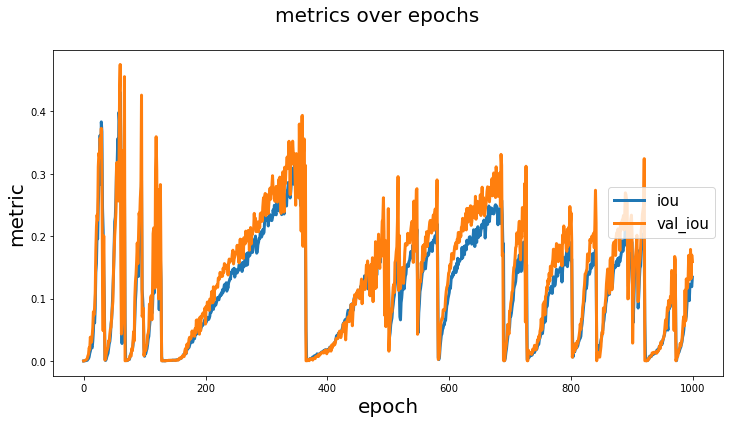

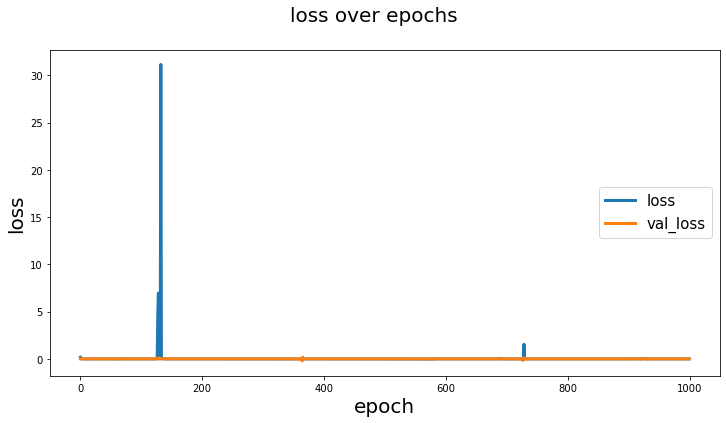

In [19]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [20]:
y_pred = model.predict(X_val)

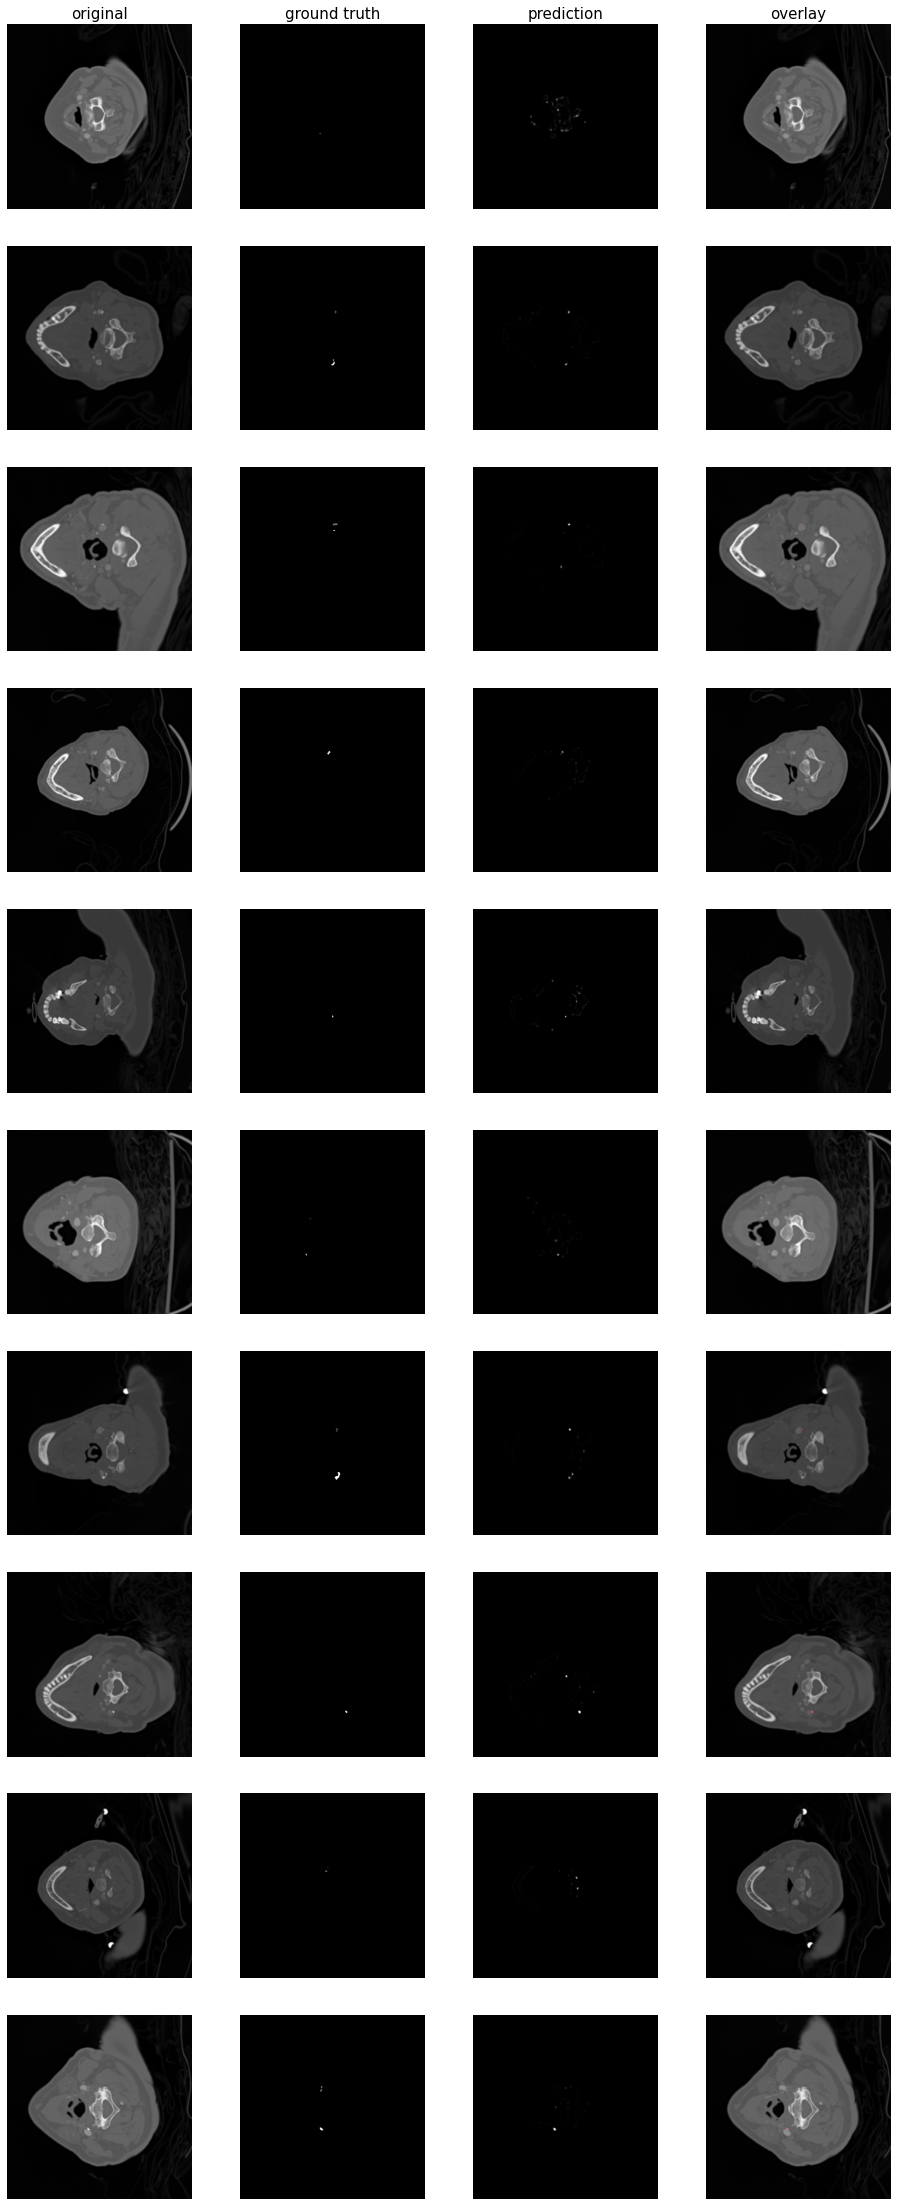

In [21]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=10)

In [22]:
loss, iou, iou_thresholded = model.evaluate(X_val, y_val)

6/6 [==============================] - 1s 189ms/step - loss: 0.0014 - iou: 0.1593 - iou_thresholded: 0.1988
